# Amazon Multivarite Stock Forecasat with LSTM

# Install Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the Data

In [ ]:
df = pd.read_csv("/content/AMZN.csv")

In [ ]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000
1,1,1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000
2,2,1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000
3,3,1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000
4,4,1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000


In [ ]:
df.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
6830,6830,2024-07-09,199.399994,200.570007,199.050003,199.339996,32700100
6831,6831,2024-07-10,200.000000,200.110001,197.690002,199.789993,32883800
6832,6832,2024-07-11,200.089996,200.270004,192.860001,195.050003,44565000
6833,6833,2024-07-12,194.800003,196.470001,193.830002,194.490005,30554000
6834,6834,2024-07-15,194.542496,196.190002,190.830002,192.720001,38808123


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6835 entries, 0 to 6834
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6835 non-null   int64  
 1   Date        6835 non-null   object 
 2   Open        6835 non-null   float64
 3   High        6835 non-null   float64
 4   Low         6835 non-null   float64
 5   Close       6835 non-null   float64
 6   Volume      6835 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 373.9+ KB


In [ ]:
# Create a date range for filtering
start_date = '2023-07-01'
end_date = '2024-07-15'

# Convert 'date' column to datetime if it isn't already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(filtered_df)


      Unnamed: 0       Date        Open        High         Low       Close  \
6575        6575 2023-07-03  130.820007  131.850006  130.070007  130.220001   
6576        6576 2023-07-05  130.240005  131.399994  129.639999  130.380005   
6577        6577 2023-07-06  128.250000  128.729996  127.370003  128.360001   
6578        6578 2023-07-07  128.589996  130.970001  128.130005  129.779999   
6579        6579 2023-07-10  129.070007  129.279999  125.919998  127.129997   
...          ...        ...         ...         ...         ...         ...   
6830        6830 2024-07-09  199.399994  200.570007  199.050003  199.339996   
6831        6831 2024-07-10  200.000000  200.110001  197.690002  199.789993   
6832        6832 2024-07-11  200.089996  200.270004  192.860001  195.050003   
6833        6833 2024-07-12  194.800003  196.470001  193.830002  194.490005   
6834        6834 2024-07-15  194.542496  196.190002  190.830002  192.720001   

        Volume  
6575  28264800  
6576  35895400  


In [ ]:
df = filtered_df.copy()

In [ ]:
# Preprocessing data (multivariate features)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Open', 'High', 'Low', 'Volume', 'Close']].values

# Preprocess the Data

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [ ]:
# Define lookback window and features
timesteps = 10
num_features = scaled_data.shape[1]

In [ ]:
# Prepare training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [ ]:
# Create dataset matrix for LSTM (multivariate)
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, :])  # Use all features, not just the first one
        y.append(dataset[i + look_back, -1])  # Predict 'Close' price
    return np.array(X), np.array(y)

In [ ]:
look_back = timesteps
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [ ]:
# Reshape input to [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# LSTM Model

In [ ]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model

In [ ]:
# Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.1035 - val_loss: 0.0255
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0310 - val_loss: 0.0627
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0136 - val_loss: 0.0307
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - val_loss: 0.0125
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - val_loss: 0.0043
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0104
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0037
Epoc

# Prediction

In [ ]:
# Predictions
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


In [ ]:
# Inverse scaling to get the original 'Close' price
# We only need the 'Close' column to be inverse scaled

# Extract the 'Close' price from the test data and predictions
scaled_close = test_data[timesteps:, -1].reshape(-1, 1)
y_test_close = np.zeros((len(scaled_close), num_features))
y_test_close[:, -1] = scaled_close.flatten()

# Inverse transform the real test data
y_test_original = scaler.inverse_transform(y_test_close)[:, -1]

# Predicting values
y_pred_close = np.zeros((len(y_pred), num_features))
y_pred_close[:, -1] = y_pred.flatten()

# Inverse transform the predicted values
y_pred_original = scaler.inverse_transform(y_pred_close)[:, -1]


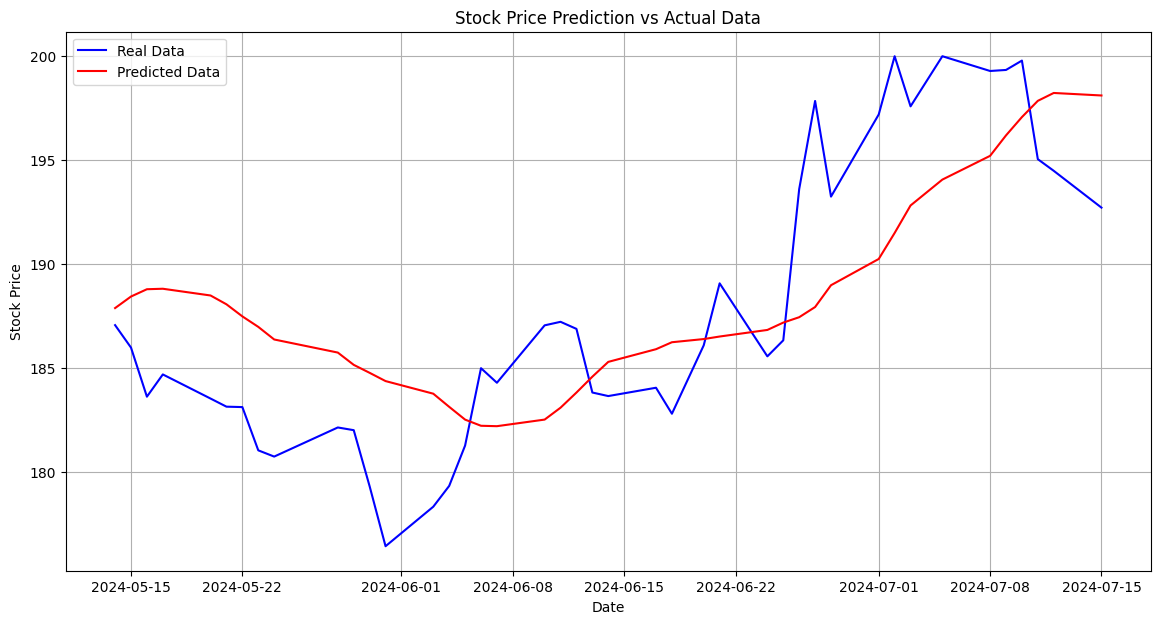

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='blue')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()



# Next 30 Days Forecast

In [ ]:
# Number of days to forecast
forecast_days = 30

# Prepare input data for forecasting
last_known_data = test_data[-look_back:]  # Last known data from the test set

# Prepare arrays to store forecast results
forecast_data = np.zeros((forecast_days, num_features))

# Perform forecasting
for i in range(forecast_days):
    # Predict next step
    next_step = model.predict(last_known_data.reshape(1, look_back, num_features))

    # Save the prediction
    forecast_data[i, -1] = next_step.flatten()

    # Update the input data for the next step
    last_known_data = np.roll(last_known_data, -1, axis=0)
    last_known_data[-1, -1] = next_step.flatten()

# Inverse transform the forecast data
forecast_data_original = scaler.inverse_transform(forecast_data)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<ipython-input-22-8373385fc4d5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_data[i, -1] = next_step.flatten()
<ipython-input-22-8373385fc4d5>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_data[-1, -1] = next_step.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


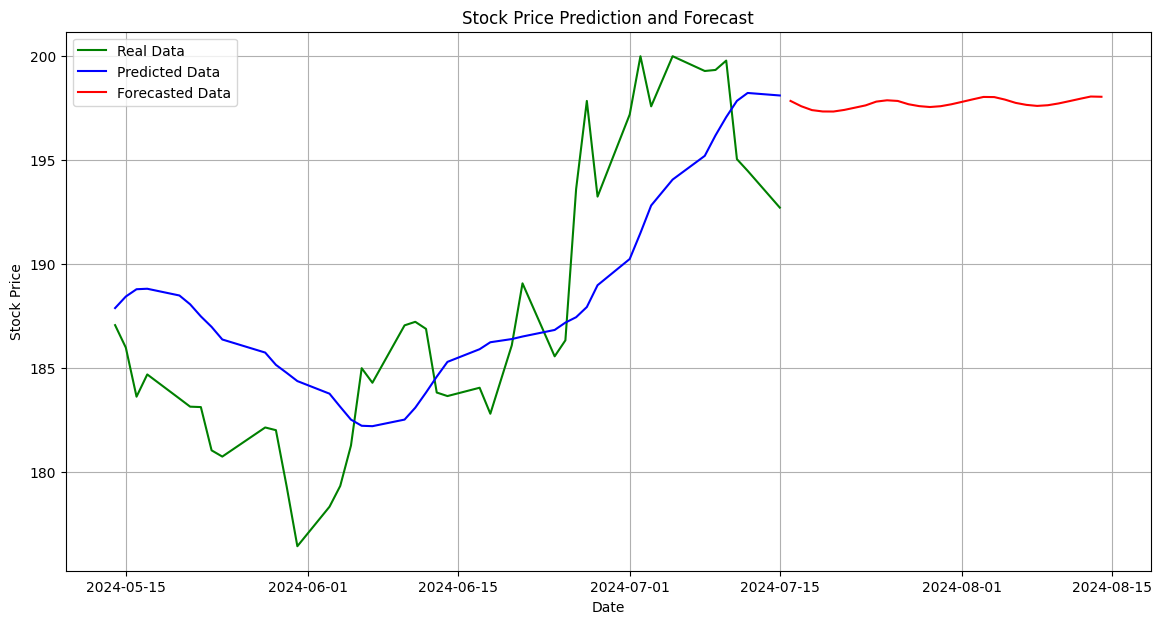

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


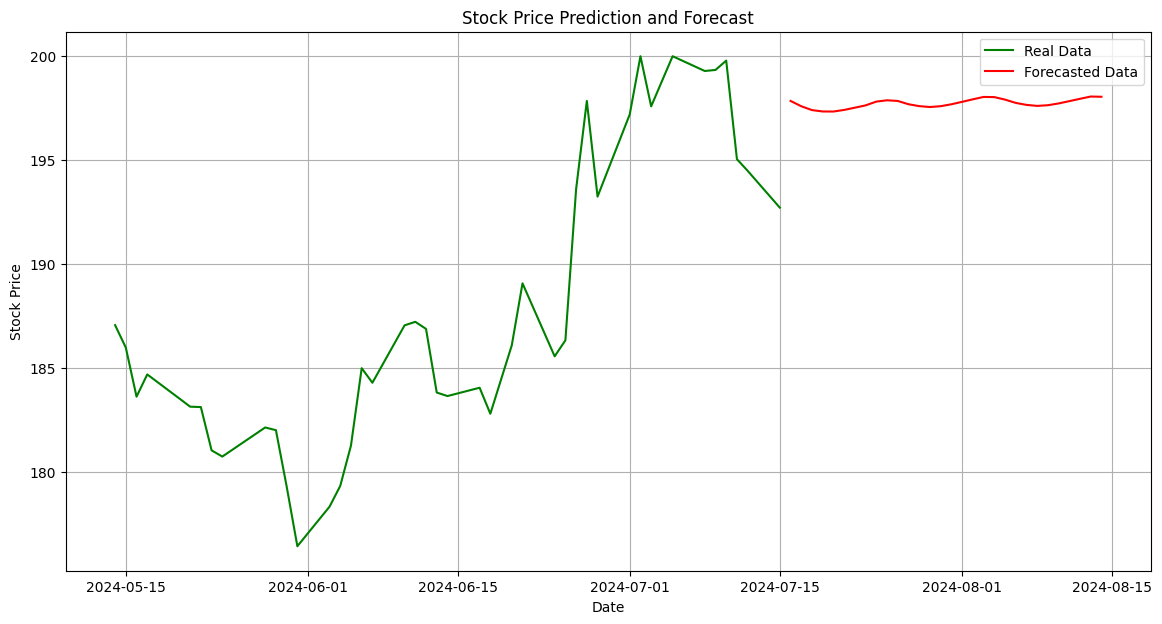

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot
plt.figure(figsize=(14,7))


# Plot the actual data
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


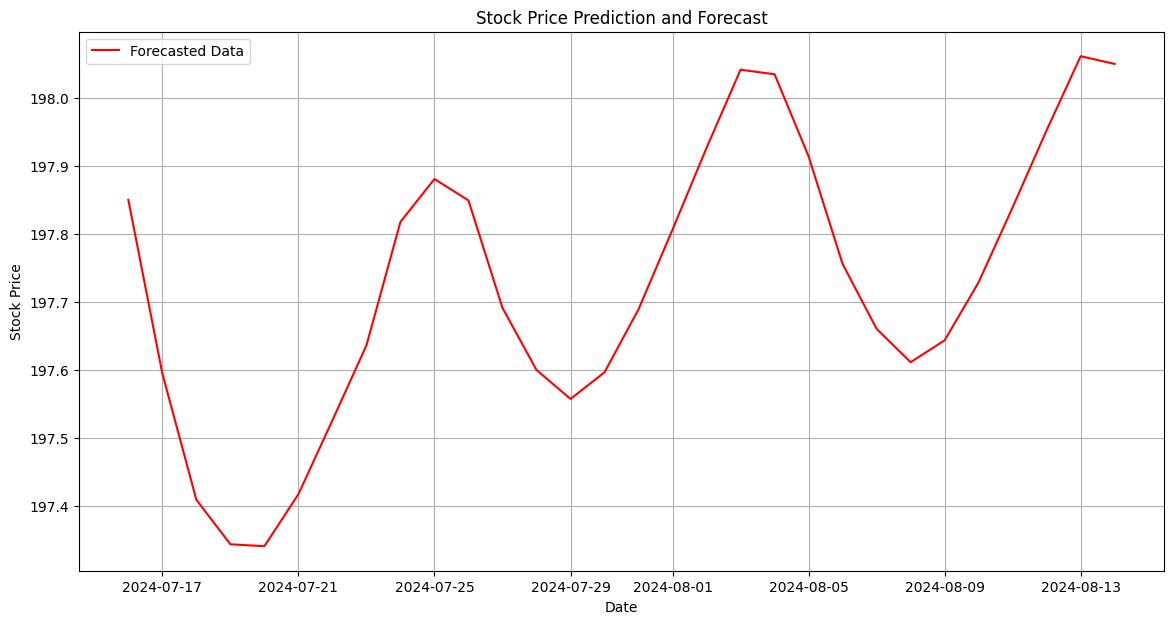

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the
plt.figure(figsize=(14,7))


# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


# Next 90 Days Forecast

In [ ]:
# Number of days to forecast
forecast_days = 90

# Prepare input data for forecasting
last_known_data = test_data[-look_back:]  # Last known data from the test set

# Prepare arrays to store forecast results
forecast_data = np.zeros((forecast_days, num_features))

# Perform forecasting
for i in range(forecast_days):
    # Predict next step
    next_step = model.predict(last_known_data.reshape(1, look_back, num_features))

    # Save the prediction
    forecast_data[i, -1] = next_step.flatten()

    # Update the input data for the next step
    last_known_data = np.roll(last_known_data, -1, axis=0)
    last_known_data[-1, -1] = next_step.flatten()

# Inverse transform the forecast data
forecast_data_original = scaler.inverse_transform(forecast_data)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-26-d52c3b6182da>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_data[i, -1] = next_step.flatten()
<ipython-input-26-d52c3b6182da>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_data[-1, -1] = next_step.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

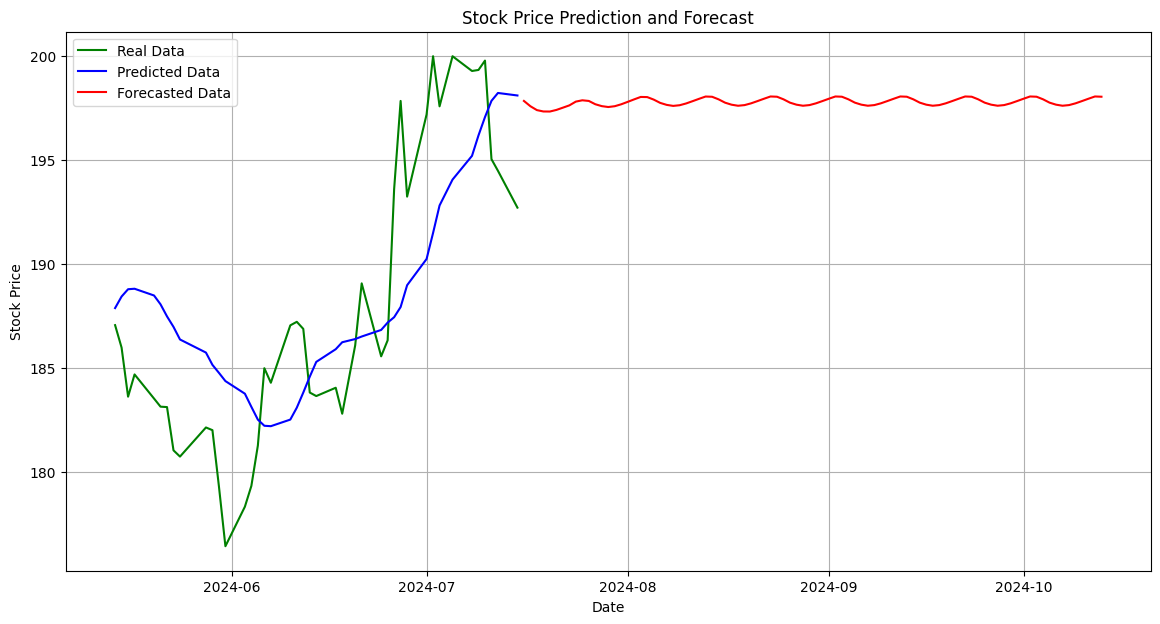

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


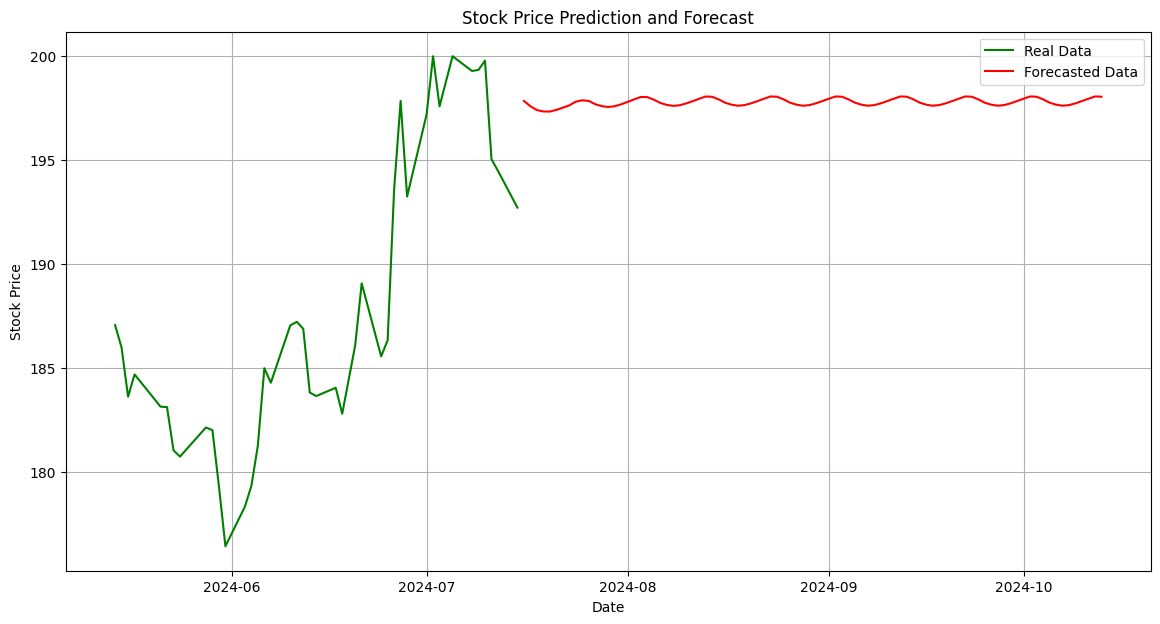

In [ ]:
plt.figure(figsize=(14,7))

# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the actual data
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


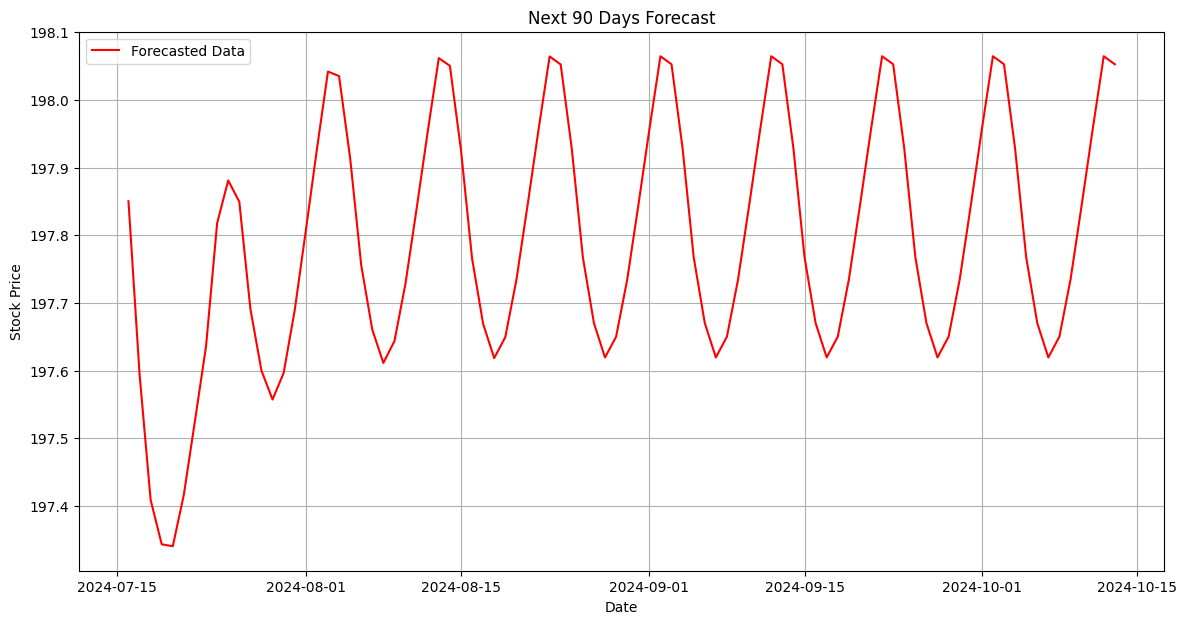

In [ ]:
plt.figure(figsize=(14,7))

# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)


# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()
